***
## notebook config

In [1]:
ON_COLAB = False
ASSESS = True

In [2]:
if ON_COLAB:
    from google.colab import drive
    from google.colab import files
    drive.mount('/content/drive', force_remount=True)
    
    !pip install --upgrade kaggle > /dev/null 2>&1
    !mkdir -p ~/.kaggle/ && cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
    
    !free -h
    
    !pip install --upgrade category_encoders > /dev/null 2>&1
    !pip install --upgrade xgboost > /dev/null 2>&1
    !pip install --upgrade optuna > /dev/null 2>&1

In [3]:
if ON_COLAB:
    !kaggle datasets download -d mavillan/meli-2021 --force --unzip
    !ls -halt
    input_path = "./"
    print("input_path:", input_path)
    subs_path = "/content/drive/MyDrive/meli2021/subs"
    print("subs_path:", subs_path)
    results_path = "/content/drive/MyDrive/meli2021/results"
    print("results_path:", results_path)
else:
    input_path = "../data"
    print("input_path:", input_path)
    subs_path = "../subs"
    print("subs_path:", subs_path)
    results_path = "../results"
    print("results_path:", results_path)

input_path: ../data
subs_path: ../subs
results_path: ../results


In [4]:
SEED = 19
SUB_NBR = "09"

***

In [5]:
from copy import deepcopy
import gc
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import interpolate
from scipy import stats
import time
import yaml

import category_encoders as ce
import xgboost as xgb
from tqdm import tqdm
from tsforest.forecast import LightGBMForecaster
import optuna

import sys
sys.path.append("../utils")
from memory import reduce_mem_usage
from metrics import RMSSE, ranked_probability_score, scoring_function, binarize_predictions
from inventory import InventoryDaysPredictor

np.random.seed(SEED)
pd.set_option('display.max_columns', None)

***
## loading data for assessment

In [10]:
if ASSESS:
    dataset = (
        pd.read_parquet(f"{input_path}/train-m2.parquet")
        .rename({"date":"ds", "sold_quantity":"y"}, axis=1,)
        .sort_values(["sku","ds"])
        .reset_index(drop=True)
    )
    
dataset["nrows"] = dataset.groupby("sku")["ds"].transform("count")
print(dataset.sku.nunique())
print(dataset.query("nrows == 30").sku.nunique())

531832
500404


In [11]:
# just for assessment
dataset = (
    dataset
    .query("nrows == 30")
    .query("ds in ('2021-02-01', '2021-03-02')")
    .reset_index(drop=True)
)
print(dataset.sku.nunique())

# skus to remove on validation
skus_to_remove = dataset.query("inventory_days > 30").sku.unique()
dataset = dataset.query("sku not in @skus_to_remove").reset_index(drop=True)
print(dataset.sku.nunique())

500404
272130


In [12]:
dataset["id_lower"] = dataset["inventory_days"].copy() 
dataset["id_upper"] = dataset["inventory_days"].copy()

idx = dataset.query("inventory_days > 30").index
dataset.loc[idx,"id_lower"] = 30
dataset.loc[idx,"id_upper"] = np.inf

In [13]:
train_dset = dataset.query("ds == '2021-02-01'").reset_index(drop=True)
valid_dset = dataset.query("ds == '2021-03-02'").reset_index(drop=True)

print(train_dset.sku.nunique())
print(valid_dset.sku.nunique())

272130
272130


In [14]:
numeric_cols = [
    "current_price",
    "listing_type_classic",
    "listing_type_premium",
    "shipping_logistic_type_fulfillment",
    "shipping_logistic_type_cross_docking",
    "shipping_logistic_type_drop_off",
    "shipping_payment_free_shipping",
    "shipping_payment_paid_shipping",
    "minutes_active",
    "weekday_1",
    "weekday_2",
    "weekday_3",
    "weekday_4",
    "weekday_5",
    "weekday_6",
    "weekday_7",
    "q_mean",
    "q_std",
    "target_stock",   
]
print("number of numeric:", len(numeric_cols))

categs_cols = [
    #"sku",
    "item_domain_id",
    #"item_id",
    #"site_id",
    "product_id",
    #"product_family_id",  
]
print("number of categs", len(categs_cols))

categs_to_encode = [
    #"sku",
    #"item_id",
    #"product_family_id",
]

target = "inventory_days"

input_cols = numeric_cols + categs_cols
print("total feats:", len(input_cols))

number of numeric: 19
number of categs 2
total feats: 21


In [15]:
train_dset.loc[:,categs_cols].nunique()

item_domain_id    7553
product_id        6445
dtype: int64

In [16]:
encoder = ce.CatBoostEncoder()
train_dset[categs_cols] = encoder.fit_transform(train_dset[categs_cols], train_dset.eval("target_stock / inventory_days"))
valid_dset[categs_cols] = encoder.transform(valid_dset[categs_cols])

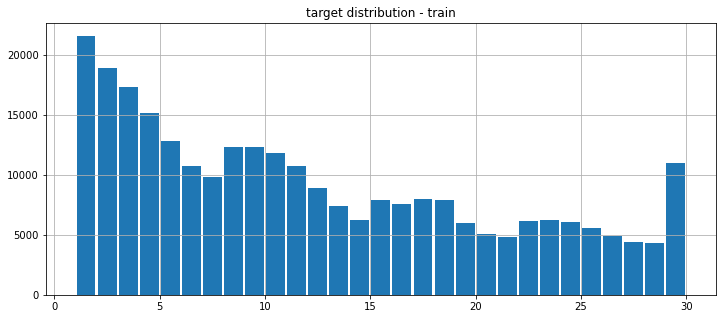

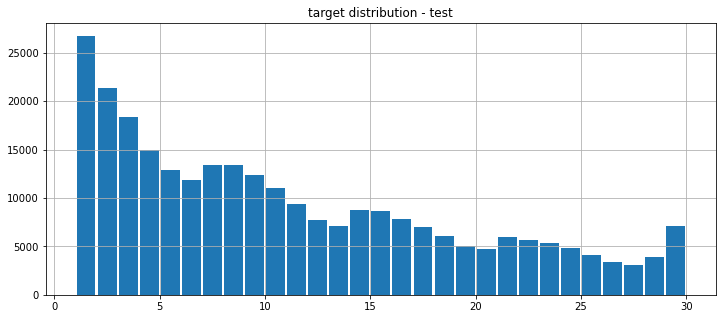

In [17]:
plt.figure(figsize=(12,5))
plt.hist(train_dset[target].values, bins=np.arange(1,31,1), rwidth=0.9)
plt.title("target distribution - train")
plt.grid()
plt.show()

plt.figure(figsize=(12,5))
plt.hist(valid_dset[target].values, bins=np.arange(1,31,1), rwidth=0.9)
plt.title("target distribution - test")
plt.grid()
plt.show()

In [18]:
print("Uncensored rows (train):", len(train_dset.query("inventory_days > 30")) / 1e3)
print("Uncensored rows (valid):", len(valid_dset.query("inventory_days > 30")) / 1e3)

Uncensored rows (train): 0.0
Uncensored rows (valid): 0.0


In [19]:
train_dset.query("sku not in @skus_to_remove").sku.nunique()

272130

In [20]:
skus_assess_m2 = train_dset.query("sku not in @skus_to_remove").sku.unique().tolist()

with open("../data/skus_assess_m2.yaml", "w") as file:
    yaml.dump(skus_assess_m2, file)
    file.close()

***
## model training: assessment

In [21]:
model_params = {
    'objective': 'survival:aft',
    'eval_metric': 'aft-nloglik',
    #'aft_loss_distribution': 'normal',
    'aft_loss_distribution': 'logistic',
    #'aft_loss_distribution': 'extreme',
    'aft_loss_distribution_scale': 1.4,
    
    #'tree_method': 'exact',
    #'tree_method': 'approx',
    'tree_method': 'hist',
    'max_bin': 256,
    
    'grow_policy': 'lossguide',
    'max_leaves': 2**6-1,
    'min_child_weight': 50,
    'max_depth': 8,
    
    'learning_rate': 0.05,
    'max_delta_step':.5,
    
    'colsample_bytree':0.8,
    'subsample':0.95,
    
    'lambda':0.1,
    'seed':SEED,
}

------------------------------------------------------------------------------------------
Training model for site: MLA 

[0]	valid-aft-nloglik:4.47503
[25]	valid-aft-nloglik:4.19489
[50]	valid-aft-nloglik:3.97659
[75]	valid-aft-nloglik:3.83165
[100]	valid-aft-nloglik:3.75502
[125]	valid-aft-nloglik:3.72797
[150]	valid-aft-nloglik:3.72300
[175]	valid-aft-nloglik:3.72236
[200]	valid-aft-nloglik:3.72230
[225]	valid-aft-nloglik:3.72235
[241]	valid-aft-nloglik:3.72242


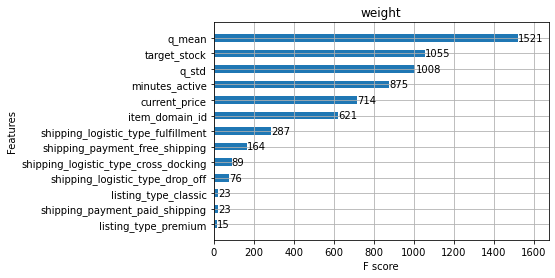

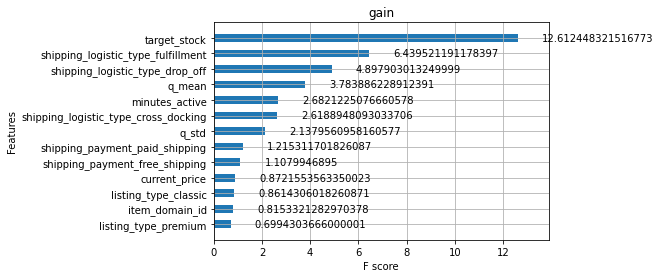

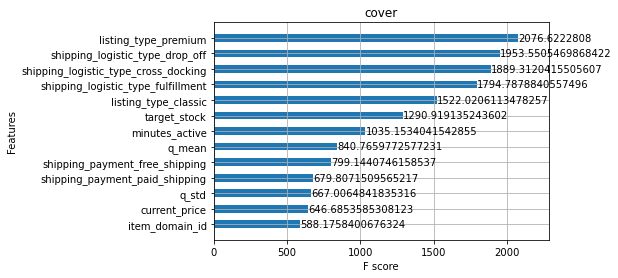

------------------------------------------------------------------------------------------
Training model for site: MLB 

[0]	valid-aft-nloglik:4.57953
[25]	valid-aft-nloglik:4.29325
[50]	valid-aft-nloglik:4.06726
[75]	valid-aft-nloglik:3.91343
[100]	valid-aft-nloglik:3.83024
[125]	valid-aft-nloglik:3.79993
[150]	valid-aft-nloglik:3.79367
[175]	valid-aft-nloglik:3.79235
[200]	valid-aft-nloglik:3.79203
[225]	valid-aft-nloglik:3.79191
[250]	valid-aft-nloglik:3.79187
[275]	valid-aft-nloglik:3.79186
[300]	valid-aft-nloglik:3.79188
[325]	valid-aft-nloglik:3.79188
[339]	valid-aft-nloglik:3.79187


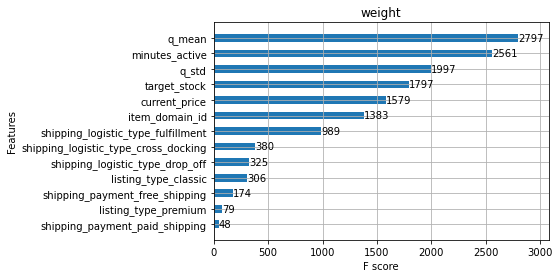

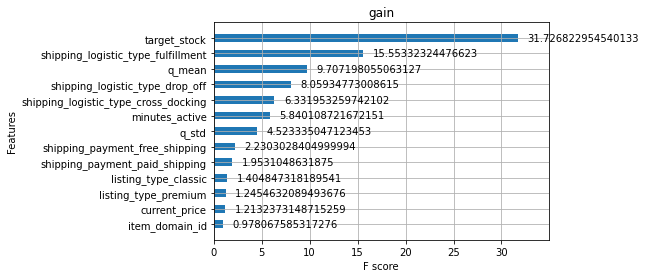

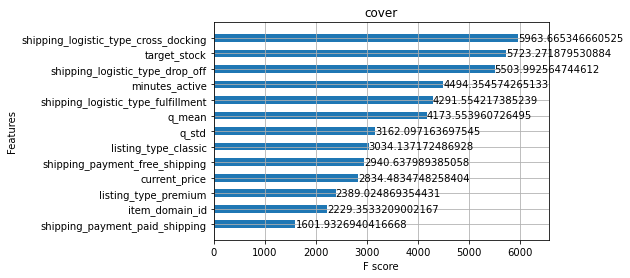

------------------------------------------------------------------------------------------
Training model for site: MLM 

[0]	valid-aft-nloglik:4.52822
[25]	valid-aft-nloglik:4.24551
[50]	valid-aft-nloglik:4.02387
[75]	valid-aft-nloglik:3.87459
[100]	valid-aft-nloglik:3.79368
[125]	valid-aft-nloglik:3.76436
[150]	valid-aft-nloglik:3.75863
[175]	valid-aft-nloglik:3.75751
[200]	valid-aft-nloglik:3.75724
[225]	valid-aft-nloglik:3.75716
[250]	valid-aft-nloglik:3.75712
[275]	valid-aft-nloglik:3.75712
[300]	valid-aft-nloglik:3.75712
[325]	valid-aft-nloglik:3.75714
[344]	valid-aft-nloglik:3.75715


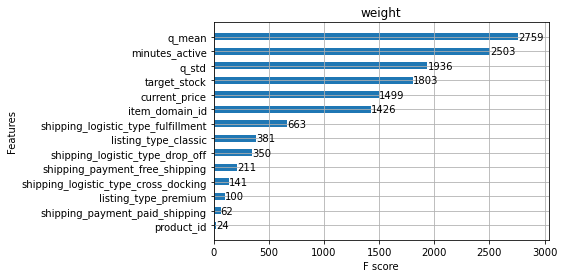

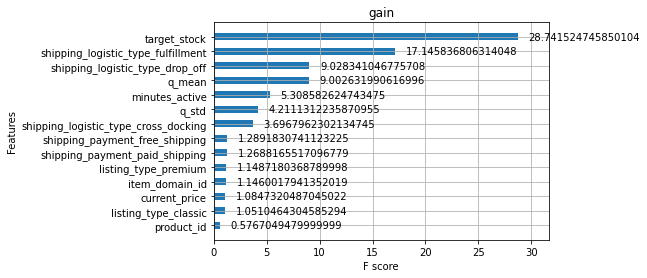

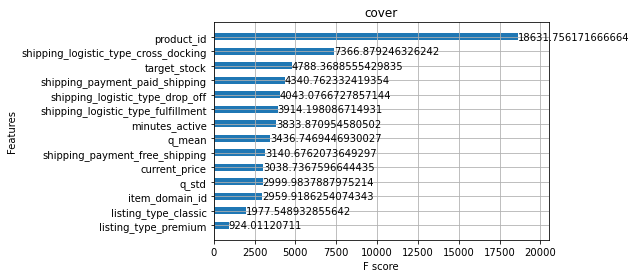

In [22]:
models_by_site = list()
sites = ["MLA","MLB","MLM"]
oof_preds = list()

for site in sites:
    print("-"*90)
    print(f"Training model for site: {site} \n")
    
    _train_dset = train_dset.query("site_id == @site").reset_index(drop=True)
    _valid_dset = valid_dset.query("site_id == @site").reset_index(drop=True)
    sample_index = _train_dset.sample(frac=0.25).index

    dtrain = xgb.DMatrix(
        data = _train_dset.loc[:, numeric_cols+categs_cols], 
    )
    dtrain.set_float_info('label_lower_bound', _train_dset.id_lower.values)
    dtrain.set_float_info('label_upper_bound', _train_dset.id_upper.values)
    
    dtrain_sample = xgb.DMatrix(
        data = _train_dset.loc[sample_index, numeric_cols+categs_cols],
    )
    dtrain_sample.set_float_info('label_lower_bound', _train_dset.loc[sample_index].id_lower.values)
    dtrain_sample.set_float_info('label_upper_bound', _train_dset.loc[sample_index].id_upper.values)

    
    dvalid = xgb.DMatrix(
        data = _valid_dset.loc[:, numeric_cols+categs_cols],
    )
    dvalid.set_float_info('label_lower_bound', _valid_dset.id_lower.values)
    dvalid.set_float_info('label_upper_bound', _valid_dset.id_upper.values)
    
    model = xgb.train(
        params = model_params,
        dtrain = dtrain,
        evals = [
            (dvalid,"valid"), 
            #(dtrain_sample,"train_sample")
        ],
        num_boost_round = 5000,
        early_stopping_rounds = 50,
        verbose_eval = 25,
    )
    
    xgb.plot_importance(model, height=0.5, importance_type="weight", title="weight")
    xgb.plot_importance(model, height=0.5, importance_type="gain", title="gain")
    xgb.plot_importance(model, height=0.5, importance_type="cover", title="cover")
    plt.show()
    
    _valid_dset["pred"] = np.clip(model.predict(dvalid), a_min=None, a_max=30)
    _valid_dset = binarize_predictions(_valid_dset)
    oof_preds.append(_valid_dset)
    models_by_site.append(model)

In [23]:
mean_aes = list()
median_aes = list()

for site,model,oof in zip(sites,models_by_site,oof_preds):
    mean_ae = oof.query("sku not in @skus_to_remove").eval("abs(inventory_days - pred)").mean()
    median_ae = oof.query("sku not in @skus_to_remove").eval("abs(inventory_days - pred)").median()
    mean_aes.append(mean_ae)
    median_aes.append(median_ae)
    print(site, "-", 
          f"best_iteration: {model.best_iteration}", "-", 
          f"best_score: {model.best_score:0.4f}", "-", 
          f"mean_ae: {mean_ae:0.4f}", "-",
          f"median_ae: {median_ae:0.4f}",
         )
    
print(f"\nAVG mae -  score: {np.mean(mean_aes):0.4f} - median_ae: {np.mean(median_aes)}")

MLA - best_iteration: 192 - best_score: 3.7223 - mean_ae: 4.5061 - median_ae: 3.3109
MLB - best_iteration: 289 - best_score: 3.7919 - mean_ae: 4.7870 - median_ae: 3.5117
MLM - best_iteration: 295 - best_score: 3.7571 - mean_ae: 4.6988 - median_ae: 3.4153

AVG mae -  score: 4.6640 - median_ae: 3.4126359621683755


***
## analysis of OOF predictions

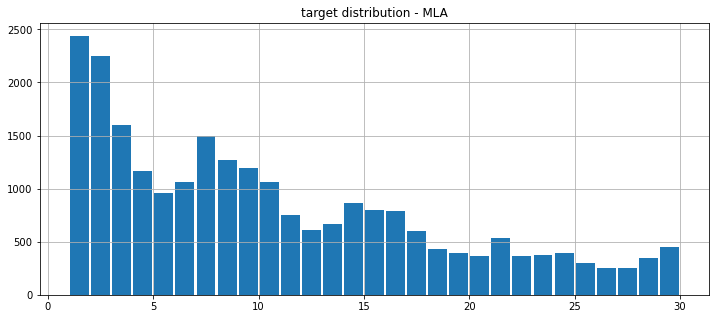

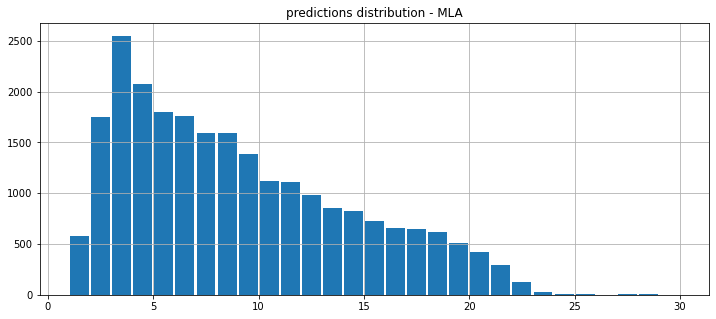

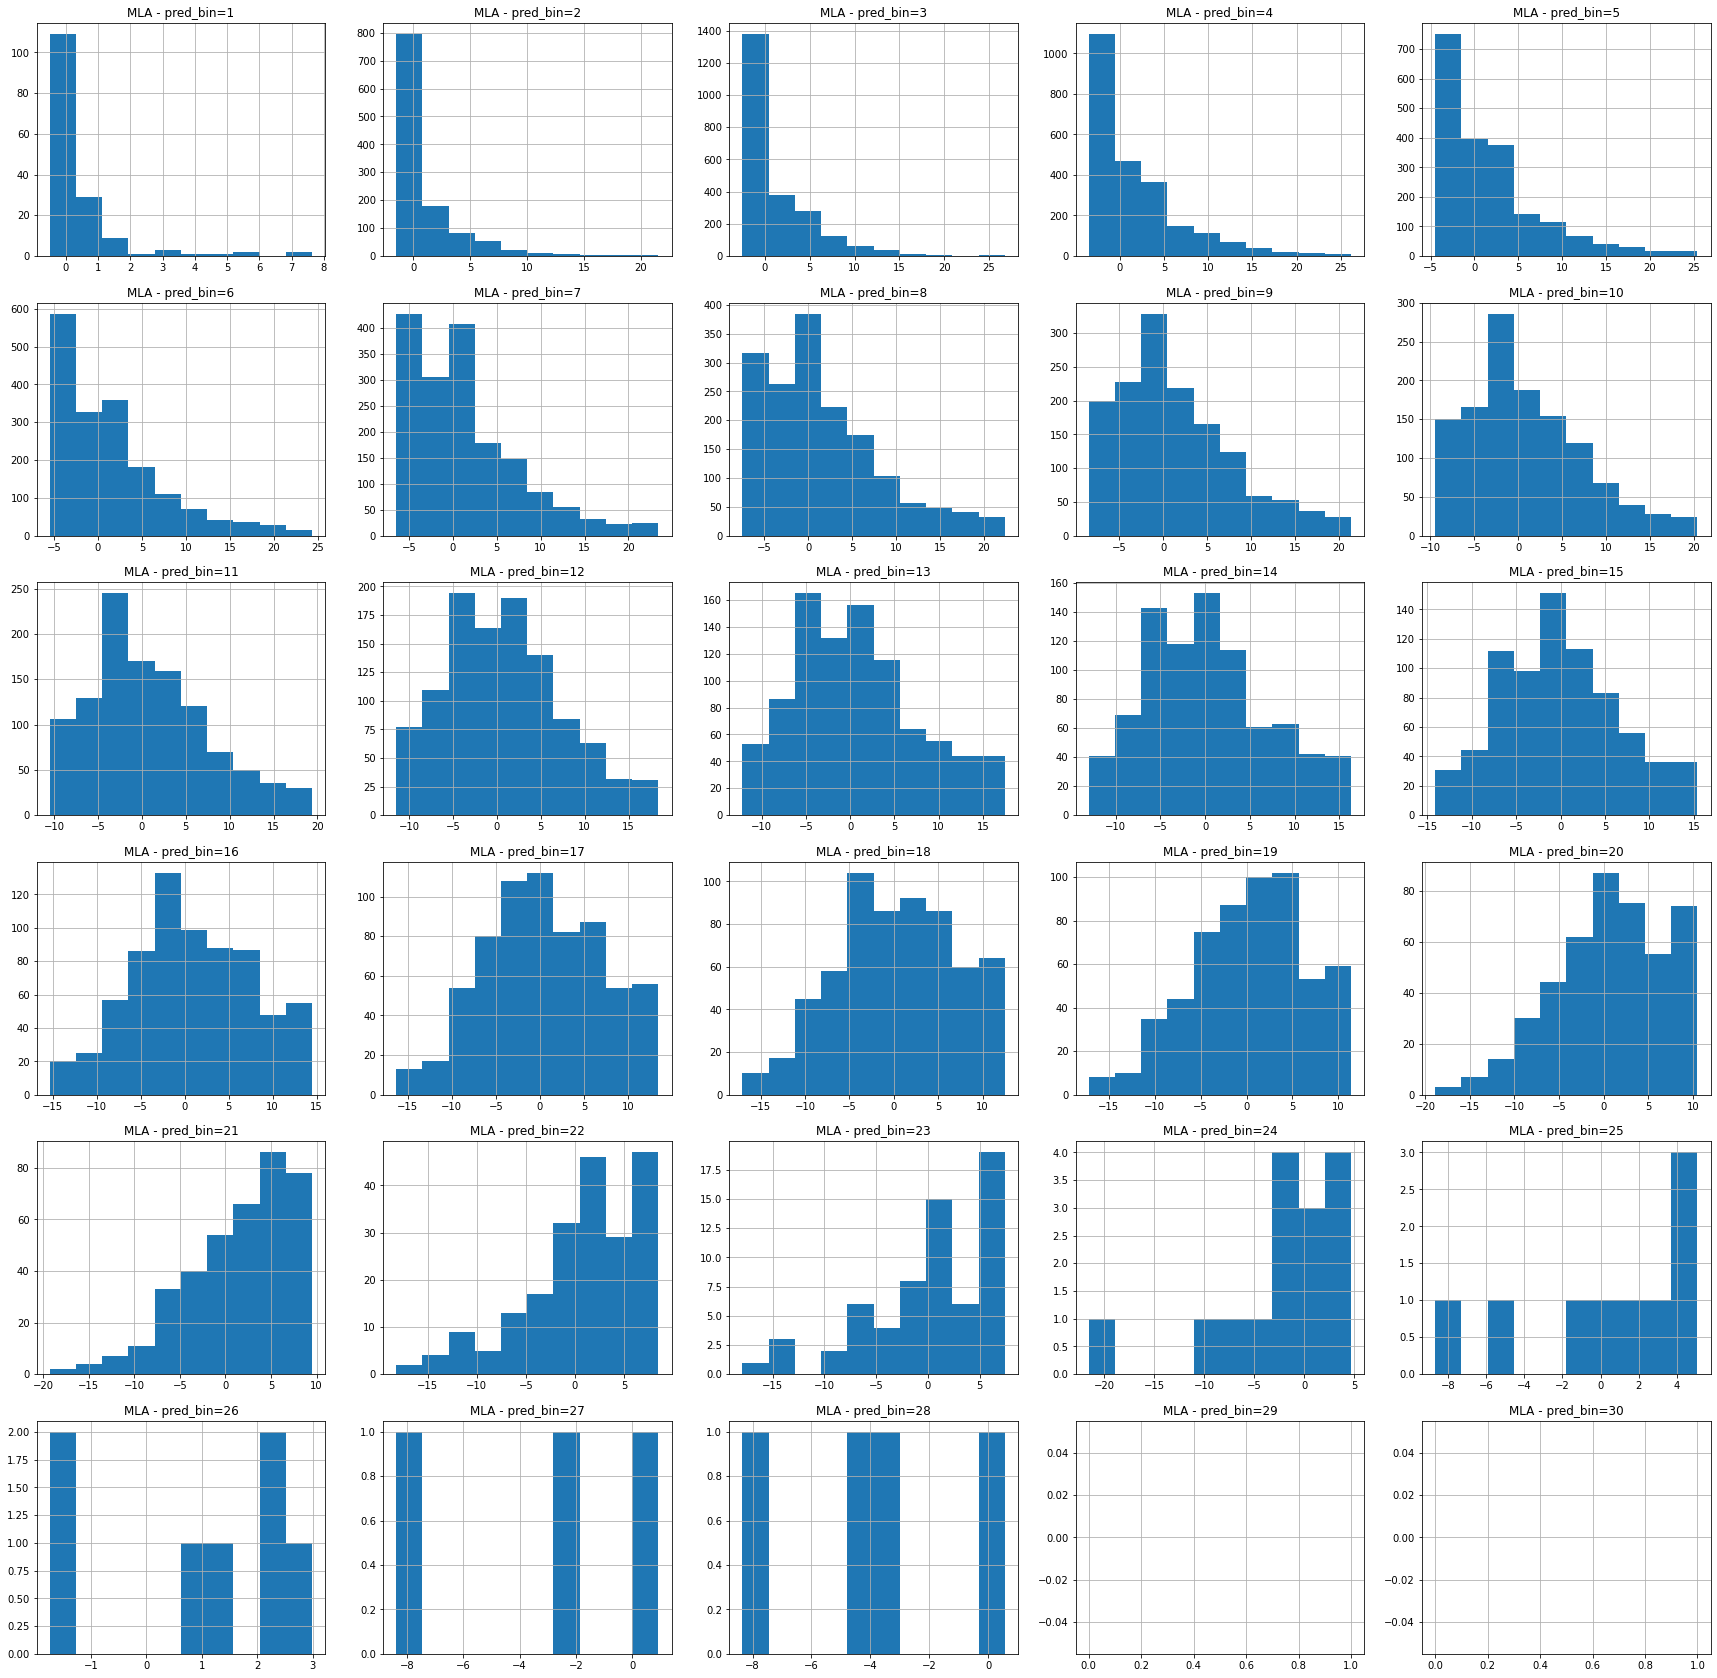

In [24]:
# results for MLA
plt.figure(figsize=(12,5))
plt.hist(oof_preds[0][target].values, bins=np.arange(1,31,1), rwidth=0.9)
plt.title("target distribution - MLA")
plt.grid()
plt.show()

plt.figure(figsize=(12,5))
plt.hist(oof_preds[0]["pred"].values, bins=np.arange(1,31,1), rwidth=0.9)
plt.title("predictions distribution - MLA")
plt.grid()
plt.show()

plt.figure(figsize=(30,30))
for d in range(1,31):
    deviation = oof_preds[0].query("pred_bin == @d").eval("inventory_days - pred")
    plt.subplot(6, 5, d)
    plt.hist(deviation.values)
    plt.title(f"MLA - pred_bin={d}")
    plt.grid()
plt.show()

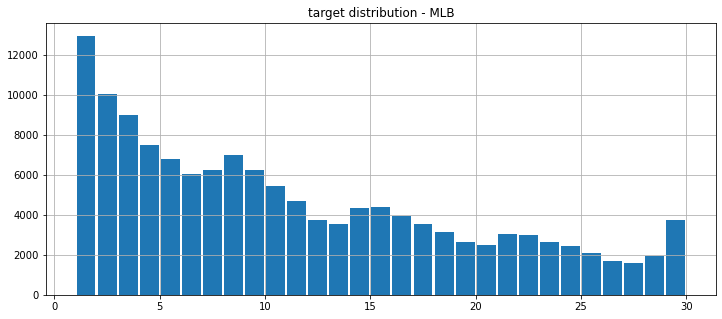

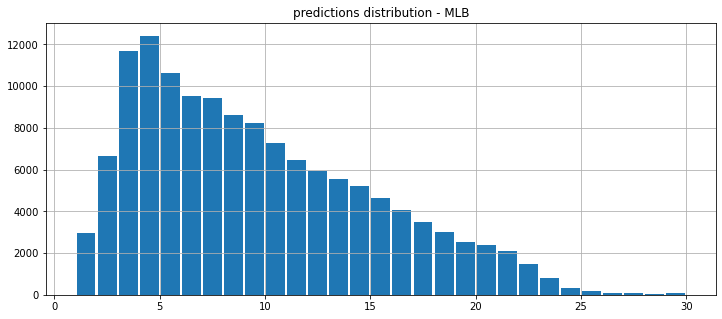

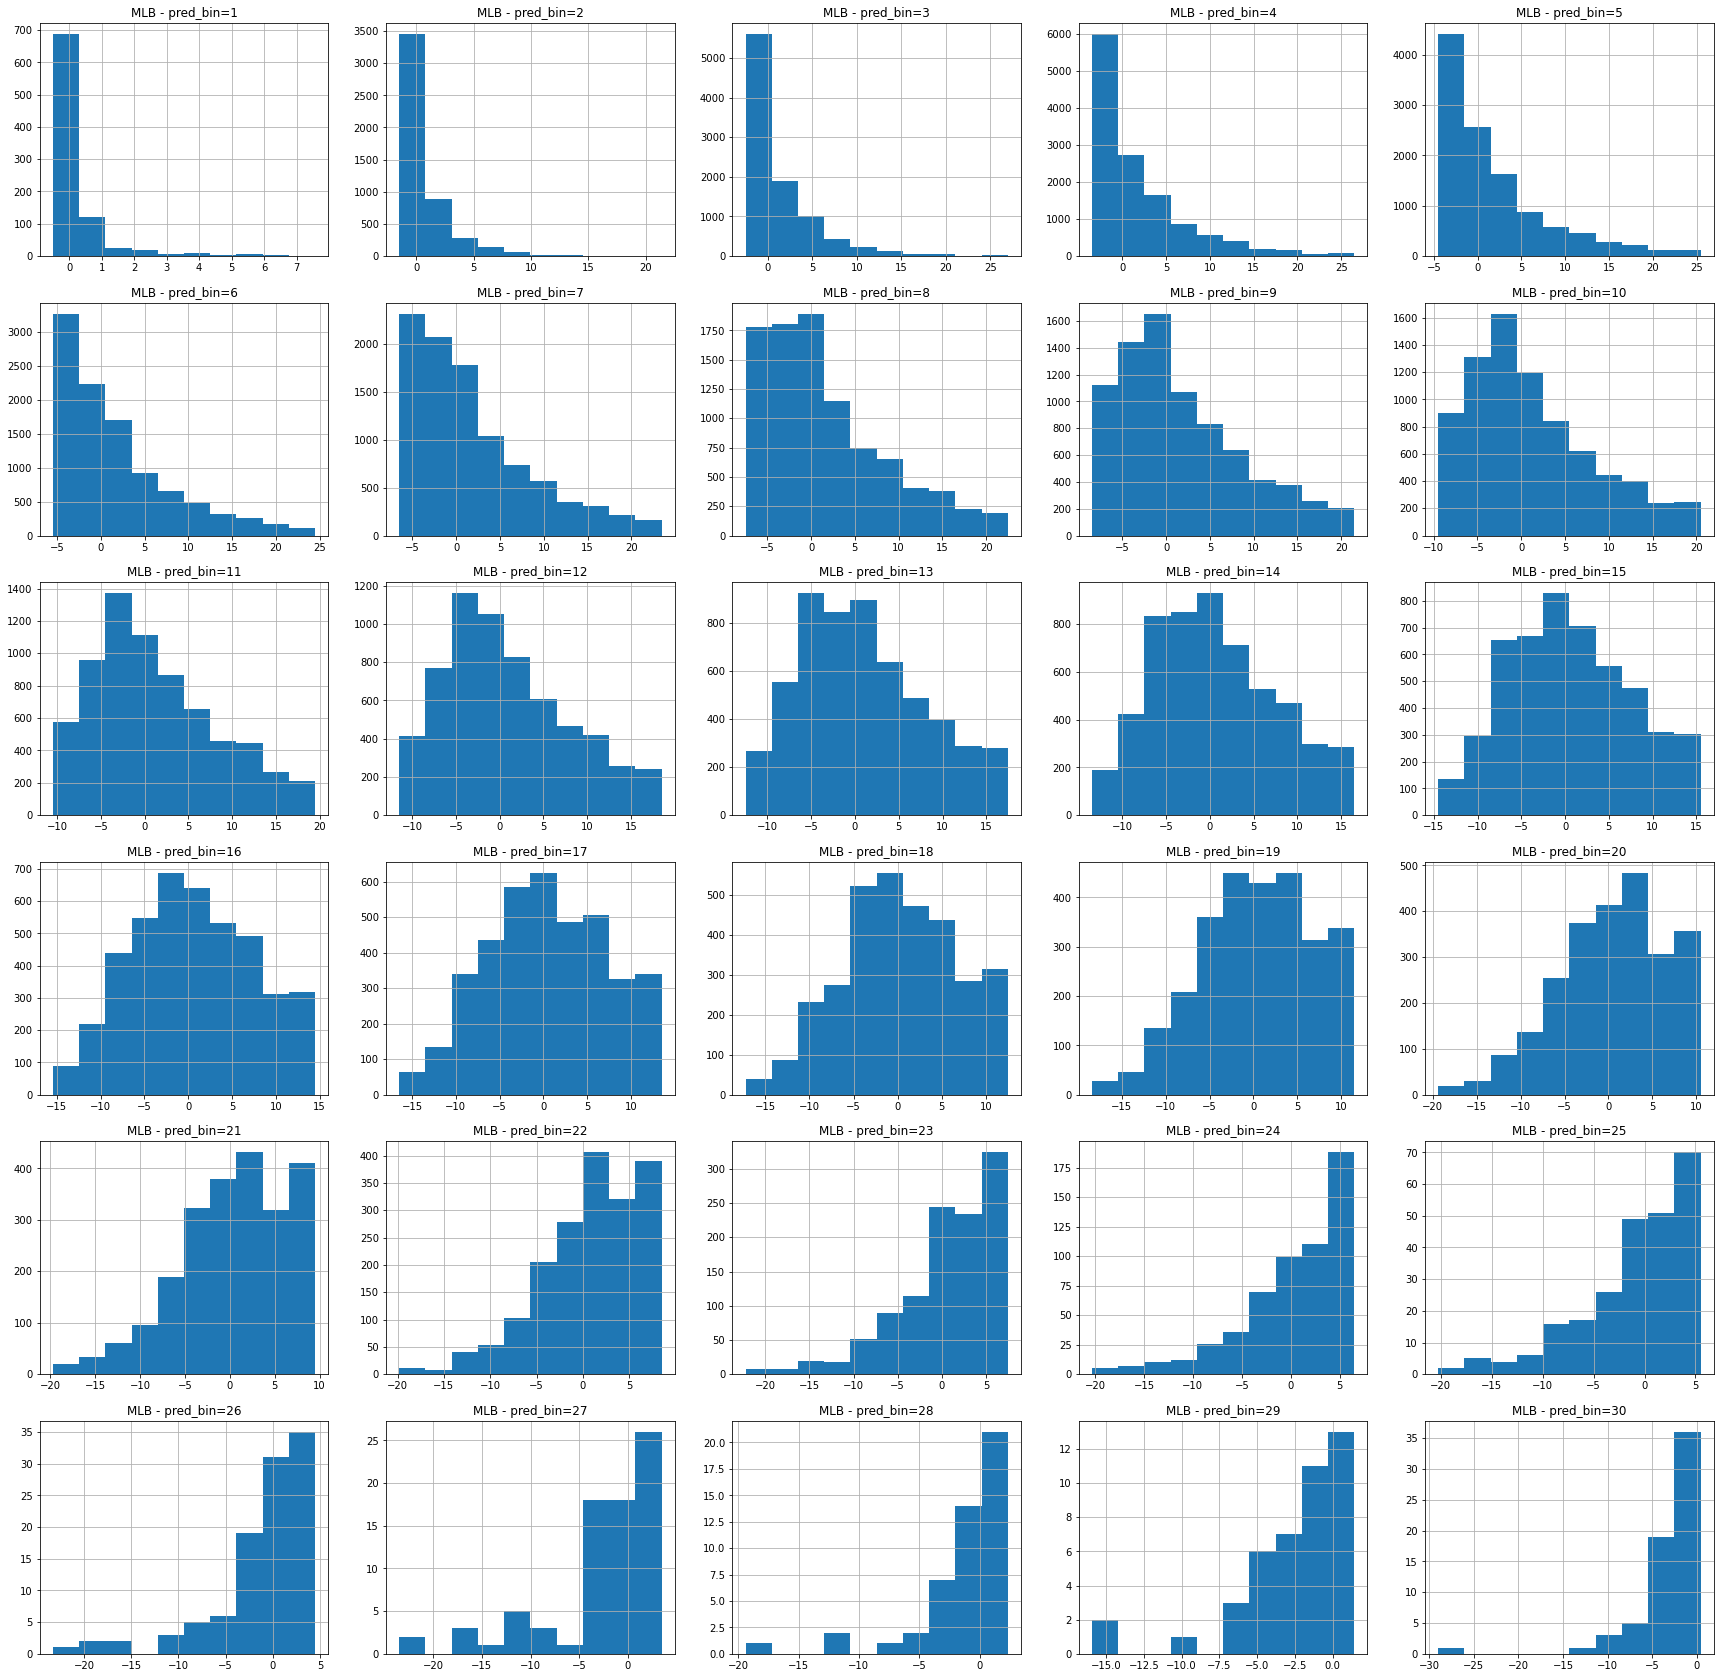

In [25]:
# results for MLB

plt.figure(figsize=(12,5))
plt.hist(oof_preds[1][target].values, bins=np.arange(1,31,1), rwidth=0.9)
plt.title("target distribution - MLB")
plt.grid()
plt.show()

plt.figure(figsize=(12,5))
plt.hist(oof_preds[1]["pred"].values, bins=np.arange(1,31,1), rwidth=0.9)
plt.title("predictions distribution - MLB")
plt.grid()
plt.show()

plt.figure(figsize=(30,30))
for d in range(1,31):
    deviation = oof_preds[1].query("pred_bin == @d").eval("inventory_days - pred")
    plt.subplot(6, 5, d)
    plt.hist(deviation.values)
    plt.title(f"MLB - pred_bin={d}")
    plt.grid()
plt.show()

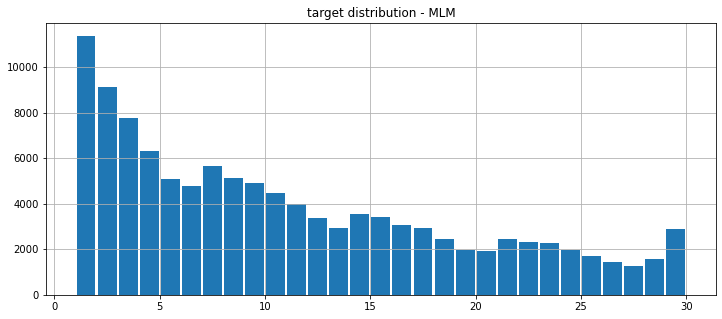

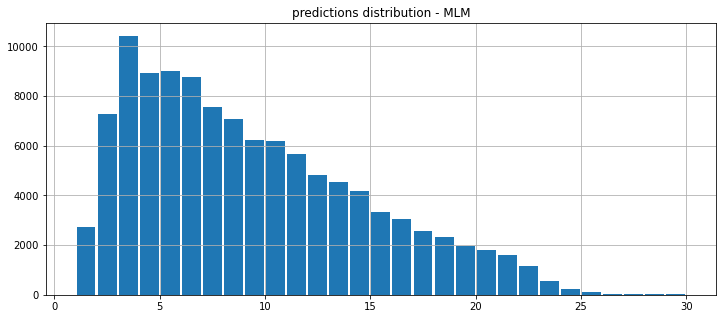

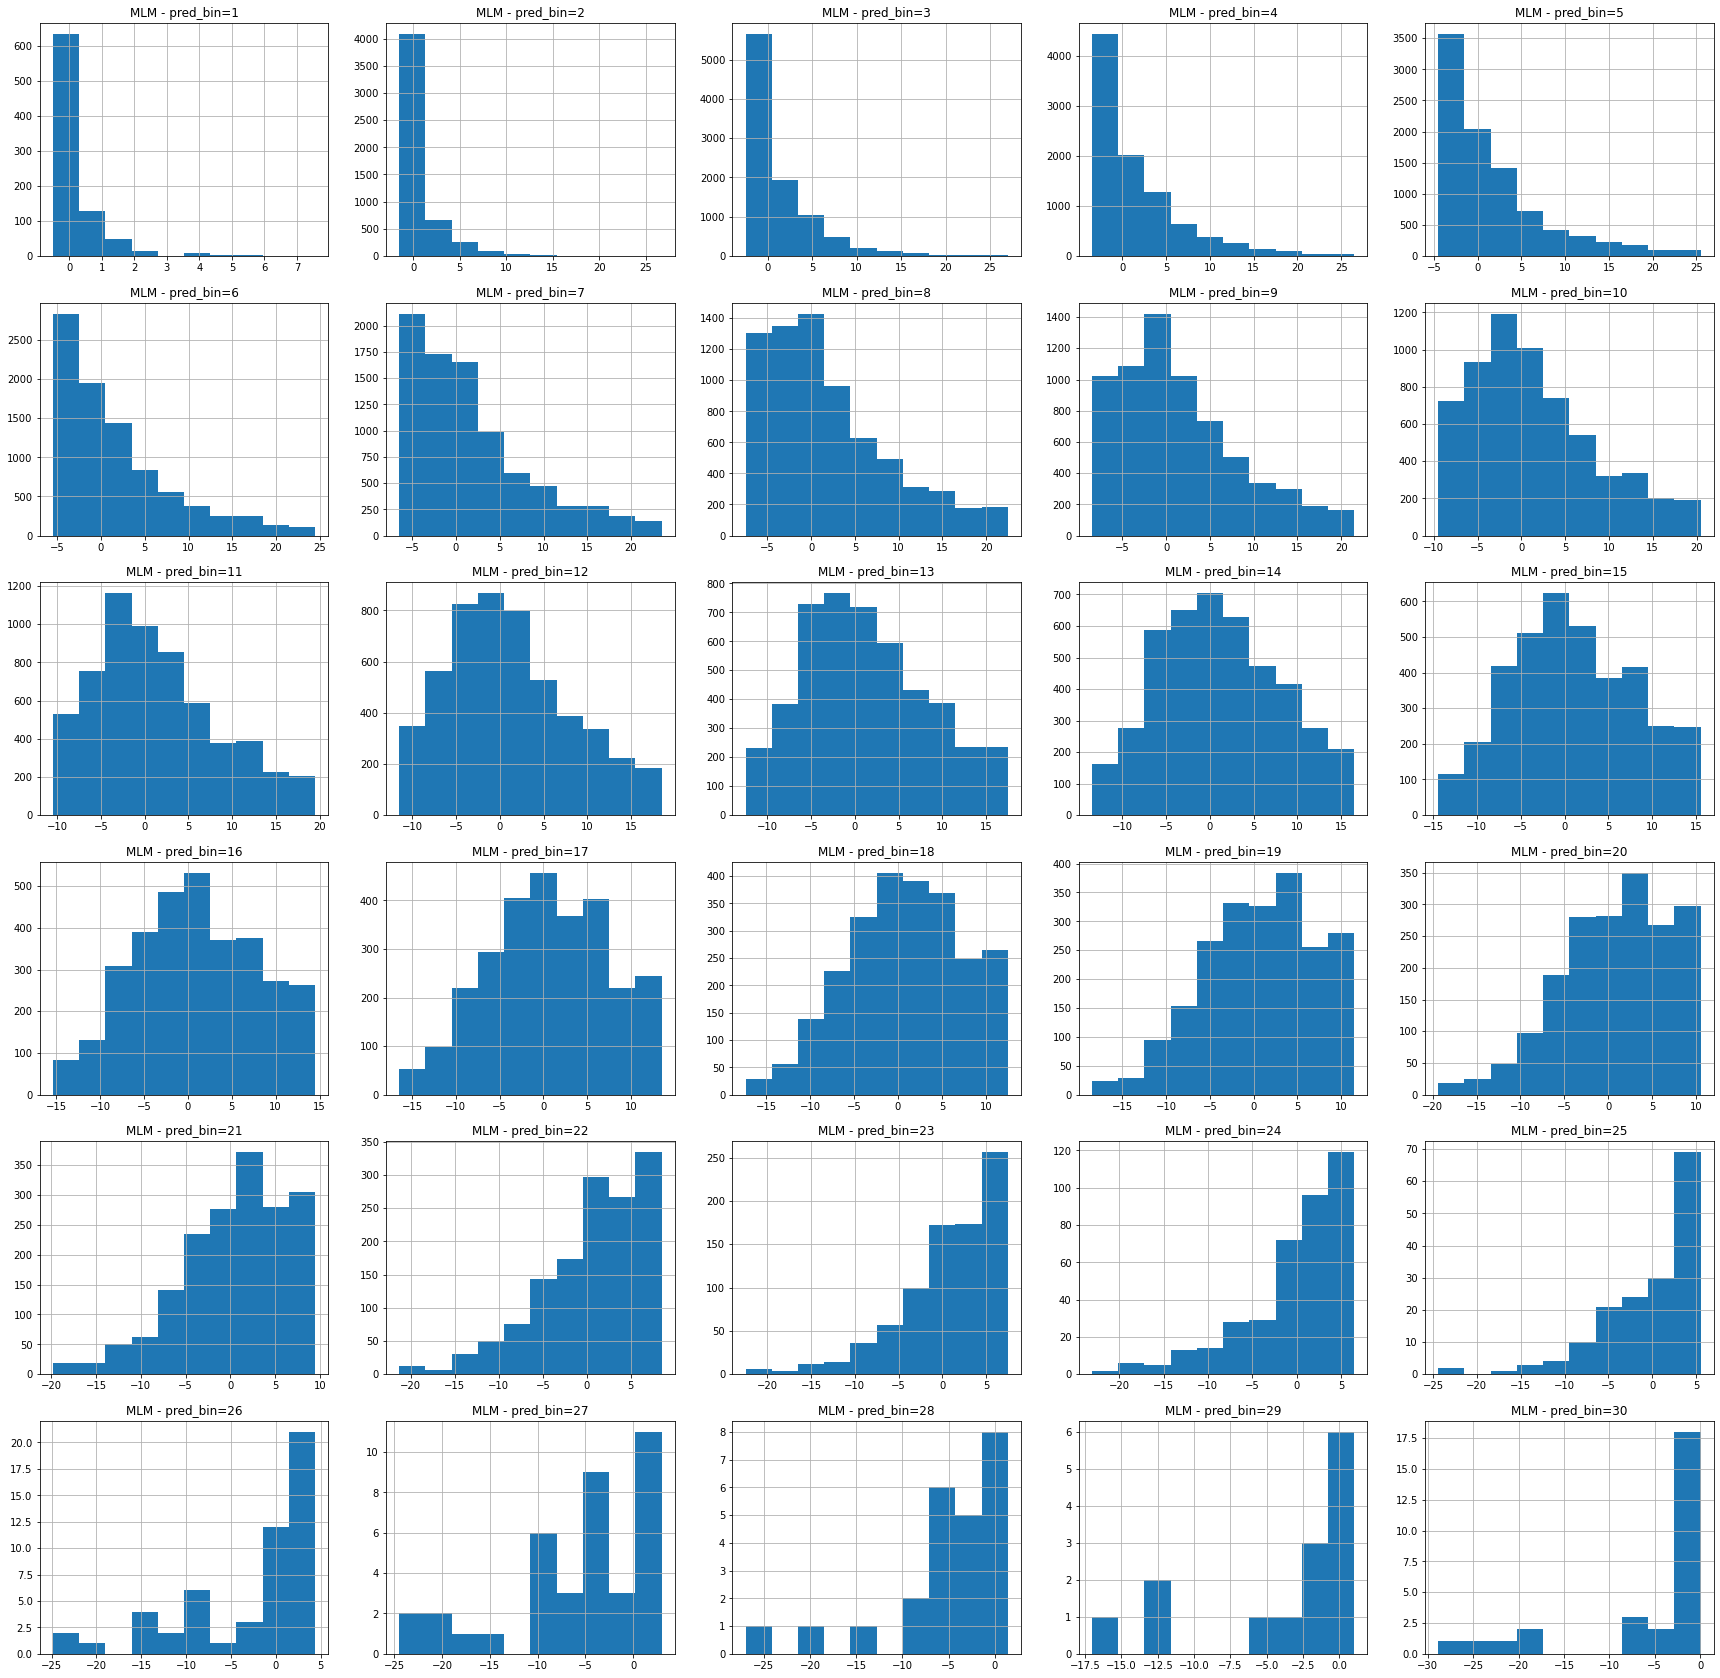

In [26]:
# results for MLM

plt.figure(figsize=(12,5))
plt.hist(oof_preds[2][target].values, bins=np.arange(1,31,1), rwidth=0.9)
plt.title("target distribution - MLM")
plt.grid()
plt.show()

plt.figure(figsize=(12,5))
plt.hist(oof_preds[2]["pred"].values, bins=np.arange(1,31,1), rwidth=0.9)
plt.title("predictions distribution - MLM")
plt.grid()
plt.show()

plt.figure(figsize=(30,30))
for d in range(1,31):
    deviation = oof_preds[2].query("pred_bin == @d").eval("inventory_days - pred")
    plt.subplot(6, 5, d)
    plt.hist(deviation.values)
    plt.title(f"MLM - pred_bin={d}")
    plt.grid()
plt.show()

***
## model training

***